In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.data_loader import *
#y
#from src.models.similarity_matrix import calculate_weighted_jaccard_similarity


In [10]:
categories = read_categories()
categories.head(3)

,article,category,level_1,level_2,level_3
0,Áedán mac Gabráin,subject.History.British History.British Histor...,History,British History,British History 1500 and before including Roma...
1,Áedán mac Gabráin,subject.People.Historical figures,People,Historical figures,None
2,Åland,subject.Countries,Countries,None,None


In [19]:
# combien de poids est donne a chaque categorie et est ce que toutes les categories sint prises en compte

# Assign Weights
level_weights = {
    'level_1': 1,
    'level_2': 2,
    'level_3': 3
}

similarity_matrix = calculate_weighted_jaccard_similarity(categories,level_weights)
similarity_matrix.head()

Computing Weighted Jaccard Similarity: 100%|██████████| 4598/4598 [00:06<00:00, 731.73it/s]


article,1 Ceres,10th century,11th century,12th century,13th century,14th century,15th Marine Expeditionary Unit,15th century,16 Cygni,16 Cygni Bb,...,Zoroaster,Zuid-Gelders,Zulu,Zürich,Áedán mac Gabráin,Åland,Édouard Manet,Éire,Óengus I of the Picts,€2 commemorative coins
article,,,,,,,,,,,,,,,,,,,,,
1 Ceres,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10th century,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11th century,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12th century,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13th century,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Similarity of article categories')

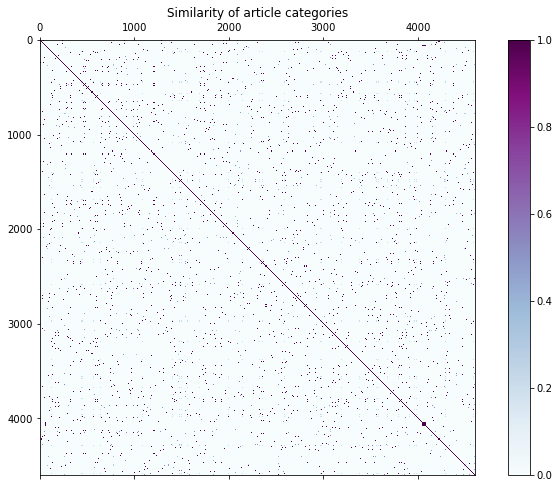

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(similarity_matrix, cmap='BuPu')
cbar = fig.colorbar(cax)
plt.title('Similarity of article categories')

# Clusters

PCA Explained Variance Ratio:
[0.01531741 0.01198842 0.01085639 0.00969214 0.00930494 0.0092063
 0.00914057 0.00910658 0.00901532 0.00886238 0.00881547 0.00878679
 0.00872684 0.00869461 0.00865109 0.00863413 0.0086233  0.00856744
 0.00850734 0.00847927 0.0084676  0.00840314 0.00836221 0.00834699
 0.00833724 0.00827824 0.00825053 0.0082285  0.00819928 0.00816226
 0.0081267  0.00810855 0.00809462 0.00807506 0.00805458 0.00804411
 0.00803698 0.00801886 0.00799819 0.00799134 0.00798794 0.00796222
 0.00793763 0.00793139 0.00791525 0.00788488 0.00786908 0.00785757
 0.00785171 0.0078462  0.00784045 0.00783543 0.00782831 0.00782413
 0.00782175 0.00781383 0.00780649 0.00779984 0.00779618 0.00779567
 0.00779384 0.00779312 0.00779192 0.00779067 0.00778883 0.00778824
 0.00778767 0.00778519 0.0077824  0.00778229 0.00778121 0.00778
 0.00777901 0.00777901 0.00777783 0.00777731 0.00777691 0.00777671
 0.00777581 0.00777334]


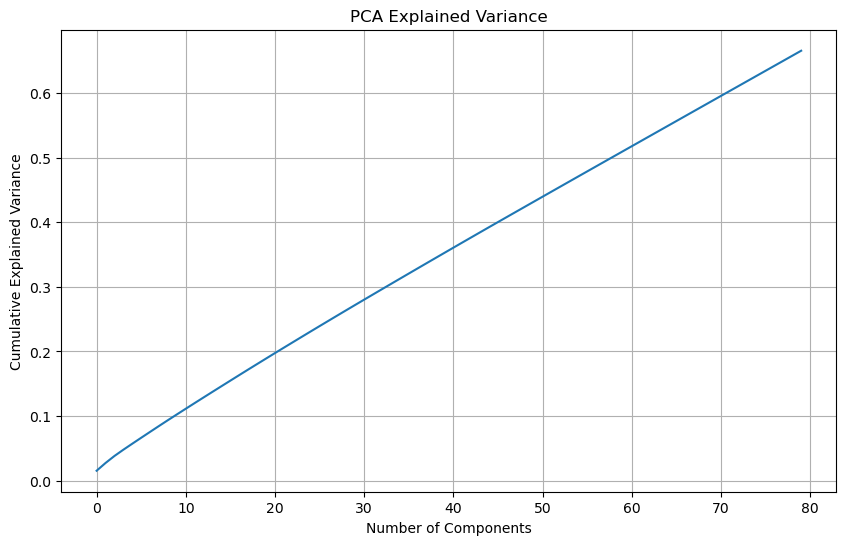

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Assume 'similarity_weighted_jaccard_df' is your similarity matrix DataFrame
# Ensure it's loaded and accessible

# Step 1: Convert Similarity to Distance
distance_matrix = 1 - similarity_weighted_jaccard_df

# Step 2: Feature Extraction via PCA
# Since K-Means requires feature vectors, we need to embed the distance matrix
# One approach is to use Multi-Dimensional Scaling (MDS), but it's computationally heavy
# Instead, we can perform PCA on the original pivot table

# Alternative Approach: Use the original category_pivot for PCA
# This avoids the computational burden of embedding from the distance matrix

# Standardize the data
scaler = StandardScaler()
category_pivot_scaled = scaler.fit_transform(category_pivot)

# Apply PCA
pca = PCA(n_components=80, random_state=42)  # Adjust n_components as needed
pca_result = pca.fit_transform(category_pivot_scaled)

# Convert PCA result to DataFrame
pca_df = pd.DataFrame(pca_result, index=category_pivot.index,
                      columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

print("PCA Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Optional: Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [6]:
from sklearn.metrics import silhouette_score

# Define range for k
k_values = range(2, 21)  # Adjust as needed

# Store silhouette scores
silhouette_scores = []

for k in tqdm(k_values, desc="Evaluating K-Means Clusters"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_df)
    score = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(10,6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Identify optimal k
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (k): {optimal_k}")


Evaluating K-Means Clusters:  11%|█         | 2/19 [00:01<00:08,  1.97it/s]


KeyboardInterrupt: 

In [ ]:
# Assuming optimal_k is determined from the previous step
k = optimal_k

# Initialize K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit and predict cluster labels
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = cluster_labels

# Display cluster distribution
print(pca_df['Cluster'].value_counts())

Cluster
1    2581
0    2017
Name: count, dtype: int64


In [ ]:
# Compute Silhouette Score
score = silhouette_score(pca_df.drop('Cluster', axis=1), pca_df['Cluster'])
print(f"Silhouette Score for k={k}: {score:.4f}")

# Compute WCSS
wcss = kmeans.inertia_
print(f"Within-Cluster Sum of Squares (WCSS) for k={k}: {wcss:.4f}")


Silhouette Score for k=2: 0.2406
Within-Cluster Sum of Squares (WCSS) for k=2: 1095921.3248


c:\Users\david\anaconda3\envs\ada\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


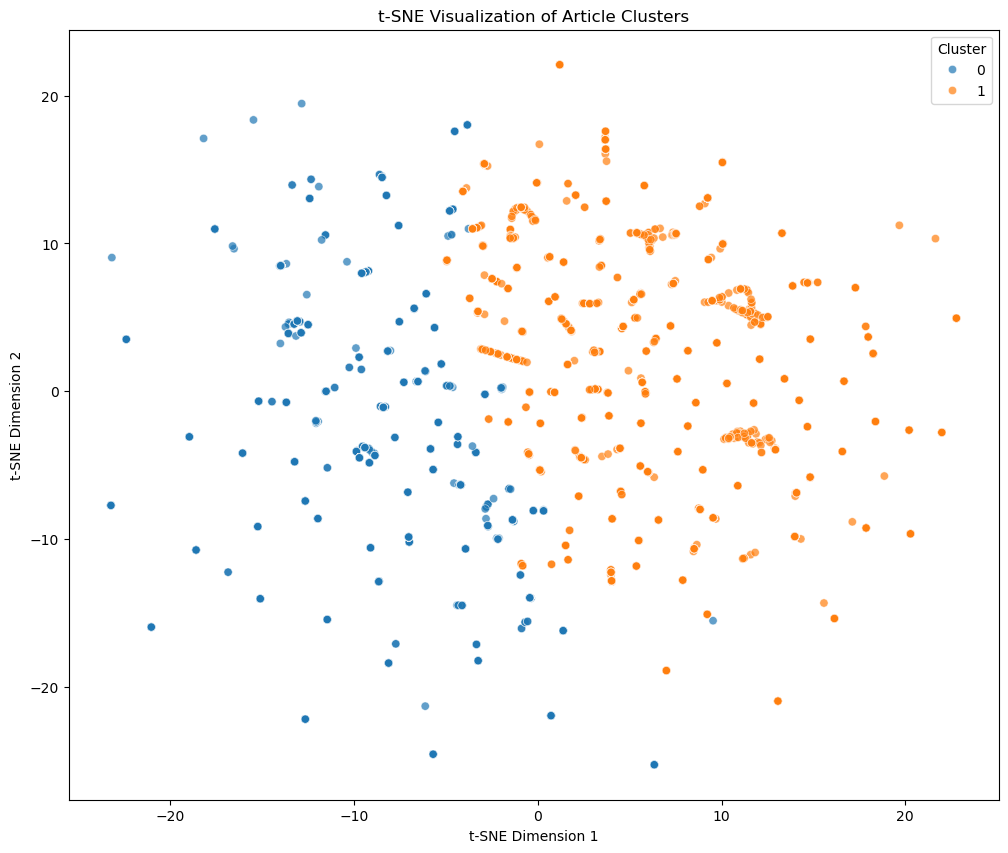

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE on PCA-reduced data
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(pca_df.drop('Cluster', axis=1))

# Add t-SNE results to DataFrame
pca_df['TSNE1'] = tsne_results[:,0]
pca_df['TSNE2'] = tsne_results[:,1]

# Plot t-SNE
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='Cluster',
    palette='tab10',
    data=pca_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Article Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Merge cluster labels with original data
clusters = pca_df['Cluster'].reset_index()
clustered_data = categories.merge(clusters, on='article')

# Example: Top categories per cluster
for cluster in sorted(clustered_data['Cluster'].unique()):
    print(f"\nCluster {cluster}:")
    top_categories = clustered_data[clustered_data['Cluster'] == cluster]['category'].value_counts().head(10)
    print(top_categories)



Cluster 0:
category
subject.Science.Biology.Birds                      161
subject.Science.Chemistry.Chemical_elements        119
subject.Science.Biology.Mammals                    114
subject.Science.Biology.Health_and_medicine        105
subject.Science.Physics.Space_Astronomy            102
subject.Everyday_life.Food_and_agriculture          96
subject.Design_and_Technology.Railway_transport     84
subject.Geography.European_Geography                82
subject.Geography.African_Geography                 79
subject.History.General_history                     77
Name: count, dtype: int64

Cluster 1:
category
subject.Countries                                                                          229
subject.Geography.Geography_of_Great_Britain                                               123
subject.People.Historical_figures                                                          104
subject.Geography.North_American_Geography                                                  99
su

# Correlations

In [54]:
paths_finished=read_finished_paths()
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th century;15th century;16th century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th century;Europe;Africa;Atlantic slave trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th century;Niger;Nigeria;British Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th century;Renaissance;Ancient Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th century;Italy;Roman Catholic Church;HIV;R...,3.0


In [55]:
tasks_finished = pd.DataFrame()

tasks_finished['source'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
tasks_finished['target'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])
tasks_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')))
tasks_finished['duration'] =  paths_finished['durationInSec']
tasks_finished['rating'] =  paths_finished['rating']

tasks_finished.head()

,source,target,path_length,duration,rating
0,14th century,African slave trade,9,166,NaN
1,14th century,African slave trade,5,88,3.0
2,14th century,African slave trade,8,138,NaN
3,14th century,Greece,4,37,NaN
4,14th century,John F. Kennedy,7,175,3.0


In [56]:
articles = read_articles()
dont_have_category = articles[~articles.isin(categories['article'])]

# Filter out rows where either 'source' or 'target' contain any article with no category
tasks_finished = tasks_finished[~tasks_finished['source'].isin(dont_have_category) & ~tasks_finished['target'].isin(dont_have_category)]

In [57]:
# Add the similarity score for each source-target pair
tasks_finished['similarity_score'] = tasks_finished.apply(
    lambda row: similarity_weighted_jaccard_df.loc[row['source'], row['target']], axis=1)

tasks_finished.head()

,source,target,path_length,duration,rating,similarity_score
0,14th century,African slave trade,9,166,NaN,1.0
1,14th century,African slave trade,5,88,3.0,1.0
2,14th century,African slave trade,8,138,NaN,1.0
3,14th century,Greece,4,37,NaN,0.0
4,14th century,John F. Kennedy,7,175,3.0,0.0


Pearson correlation: PearsonRResult(statistic=-0.08168899945946637, pvalue=1.335582594640559e-76)
Spearman correlation: SignificanceResult(statistic=-0.1582221411196722, pvalue=1.645906378693104e-284)


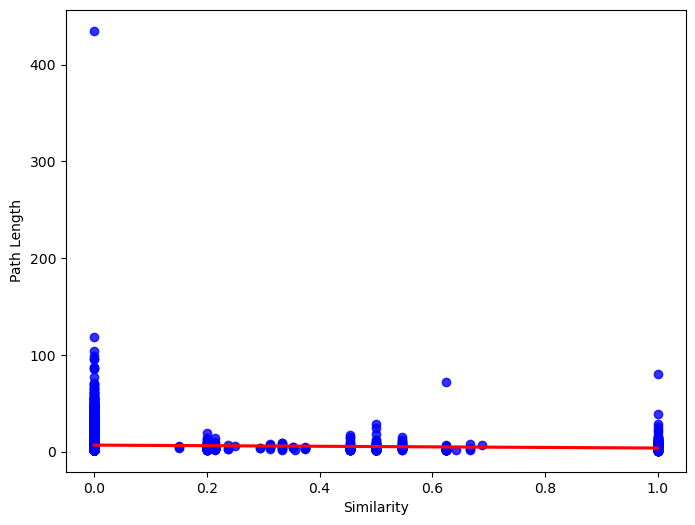

In [44]:
from scipy import stats
import seaborn as sns
p = stats.pearsonr(tasks_finished["similarity_score"], tasks_finished["path_length"])
s = stats.spearmanr(tasks_finished["similarity_score"], tasks_finished["path_length"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="similarity_score", y="path_length", data=tasks_finished, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Similarity')
plt.ylabel('Path Length')
plt.show()

In [45]:
tasks_finished.describe()

,path_length,duration,rating,similarity_score
count,51249.000000,51249.000000,28475.000000,51249.000000
mean,6.757381,158.256044,2.269745,0.018364
std,4.680603,360.793518,1.110352,0.126438
min,1.000000,0.000000,1.000000,0.000000
25%,5.000000,60.000000,1.000000,0.000000
50%,6.000000,107.000000,2.000000,0.000000
75%,8.000000,183.000000,3.000000,0.000000
max,435.000000,35091.000000,5.000000,1.000000


Let's see what happen if we zoom into shorts path (75% of total number)

Pearson correlation: PearsonRResult(statistic=-0.19106890253500394, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=-0.17171826795205827, pvalue=5.967483203178853e-273)


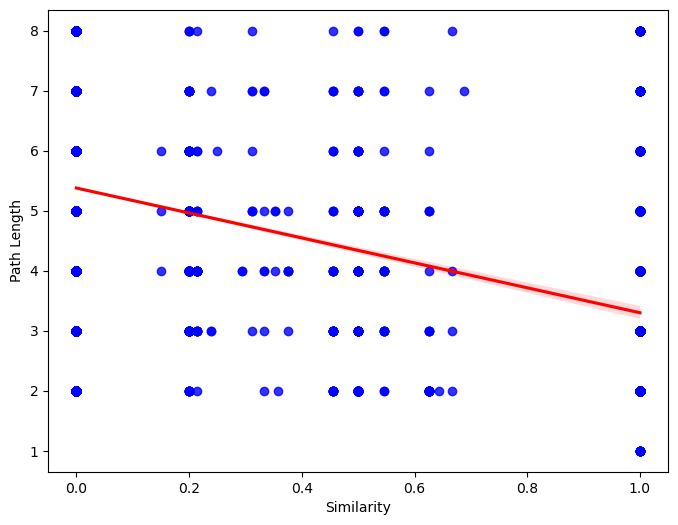

In [30]:
tasks_finished_shorts = tasks_finished[tasks_finished['path_length'] < 9]

p = stats.pearsonr(tasks_finished_shorts["similarity_score"], tasks_finished_shorts["path_length"])
s = stats.spearmanr(tasks_finished_shorts["similarity_score"], tasks_finished_shorts["path_length"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="similarity_score", y="path_length", data=tasks_finished_shorts, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Similarity')
plt.ylabel('Path Length')
plt.show()

Pearson correlation: PearsonRResult(statistic=-0.03607284359501756, pvalue=3.1168676887764507e-16)
Spearman correlation: SignificanceResult(statistic=-0.14051377289940306, pvalue=3.0585345246561114e-224)


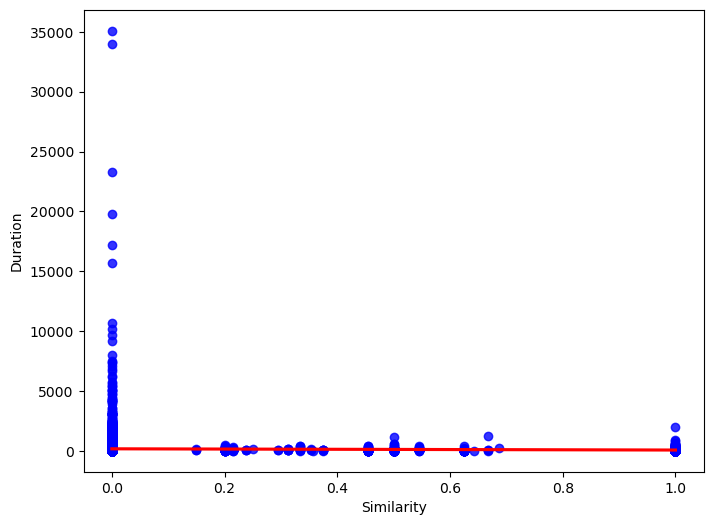

In [31]:
p = stats.pearsonr(tasks_finished["similarity_score"], tasks_finished["duration"])
s = stats.spearmanr(tasks_finished["similarity_score"], tasks_finished["duration"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="similarity_score", y="duration", data=tasks_finished, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Similarity')
plt.ylabel('Duration')
plt.show()

Here with 75% of total runs:

Pearson correlation: PearsonRResult(statistic=-0.14802712952732833, pvalue=1.9513252077938758e-187)
Spearman correlation: SignificanceResult(statistic=-0.15101316426684486, pvalue=4.456084287731628e-195)


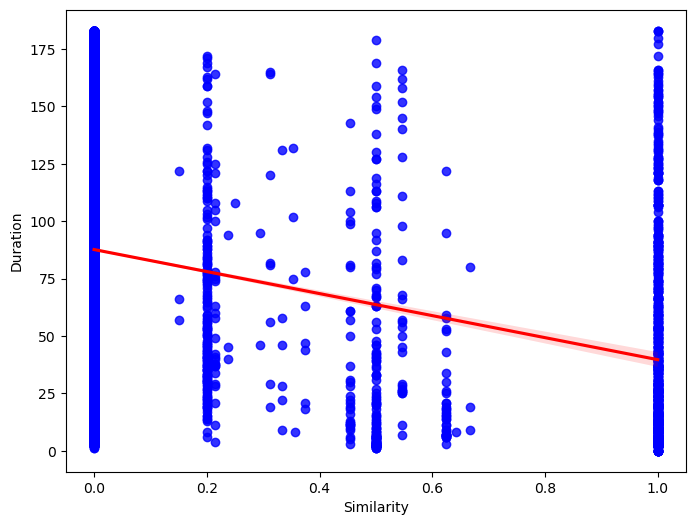

In [32]:
tasks_finished_shorts = tasks_finished[tasks_finished['duration'] <= 183]

p = stats.pearsonr(tasks_finished_shorts["similarity_score"], tasks_finished_shorts["duration"])
s = stats.spearmanr(tasks_finished_shorts["similarity_score"], tasks_finished_shorts["duration"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="similarity_score", y="duration", data=tasks_finished_shorts, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Similarity')
plt.ylabel('Duration')
plt.show()

Pearson correlation: PearsonRResult(statistic=-0.05814457097987231, pvalue=9.279892649265566e-23)
Spearman correlation: SignificanceResult(statistic=-0.07795664304412417, pvalue=1.2337190026950272e-39)


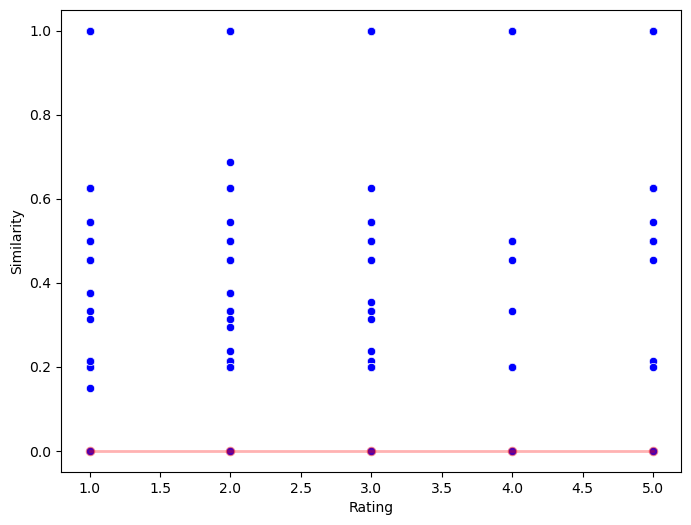

,rating,similarity_score
0,1.0,0.0
1,2.0,0.0
2,3.0,0.0
3,4.0,0.0
4,5.0,0.0


In [33]:
tasks_finished_rating=tasks_finished.dropna(subset=['rating'])

p = stats.pearsonr(tasks_finished_rating["similarity_score"], tasks_finished_rating["rating"])
s = stats.spearmanr(tasks_finished_rating["similarity_score"], tasks_finished_rating["rating"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

median_ratings = tasks_finished.groupby('rating')['similarity_score'].median().reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="rating", y="similarity_score", data=tasks_finished, color='blue')
plt.plot(median_ratings['rating'], median_ratings['similarity_score'], color='red', lw=2, marker='o', alpha=0.3)
plt.xlabel('Rating')
plt.ylabel('Similarity')
plt.show()

median_ratings

### Difficult accessibility

In [35]:
links = read_links()
links.head()

,linkSource,linkTarget
0,Áedán mac Gabráin,Bede
1,Áedán mac Gabráin,Columba
2,Áedán mac Gabráin,Dál Riata
3,Áedán mac Gabráin,Great Britain
4,Áedán mac Gabráin,Ireland


In [46]:
# Count how many links on an article
source_counts = links.groupby('linkSource').size().reset_index(name='source_count')
source_counts_sorted = source_counts.sort_values(by='source_count', ascending=False).reset_index(drop=True)

# Count how many time an article is cited in others
target_counts = links.groupby('linkTarget').size().reset_index(name='target_count')
target_counts_sorted = target_counts.sort_values(by='target_count', ascending=False).reset_index(drop=True)

print("Sorted Counts by linkSource:")
print(source_counts_sorted)

print("\nSorted Counts by linkTarget:")
print(target_counts_sorted)

Sorted Counts by linkSource:
                          linkSource  source_count
0                      United States           294
1       Driving on the left or right           255
2                  List of countries           244
3     List of circulating currencies           236
4           List of sovereign states           216
...                              ...           ...
4582             Hello Garci scandal             1
4583              Friend Directdebit             1
4584                  Soil structure             1
4585             Pere Marquette 1225             1
4586                    Soil profile             1

[4587 rows x 2 columns]

Sorted Counts by linkTarget:
                       linkTarget  target_count
0                   United States          1551
1                  United Kingdom           972
2                          France           959
3                          Europe           933
4                    World War II           751
...             

In [58]:
# Merge 'tasks_finished' with 'source_counts' on 'source' to get 'goes_to' count
tasks_finished = tasks_finished.merge(source_counts_sorted[['linkSource', 'source_count']], 
                                      left_on='source', 
                                      right_on='linkSource', 
                                      how='left').drop(columns=['linkSource'])

# Rename the column to 'goes_to'
tasks_finished = tasks_finished.rename(columns={'source_count': 'source_goes_to'})

# Merge 'tasks_finished' with 'target_counts' on 'target' to get 'reached_by' count
tasks_finished = tasks_finished.merge(target_counts_sorted[['linkTarget', 'target_count']], 
                                      left_on='target', 
                                      right_on='linkTarget', 
                                      how='left').drop(columns=['linkTarget'])

# Rename the column to 'reached_by'
tasks_finished = tasks_finished.rename(columns={'target_count': 'target_reached_by'})

tasks_finished = tasks_finished.dropna(subset=['target_reached_by', 'source_goes_to'])

tasks_finished.head()


,source,target,path_length,duration,rating,similarity_score,source_goes_to,target_reached_by
0,14th century,African slave trade,9,166,NaN,1.0,31,7.0
1,14th century,African slave trade,5,88,3.0,1.0,31,7.0
2,14th century,African slave trade,8,138,NaN,1.0,31,7.0
3,14th century,Greece,4,37,NaN,0.0,31,246.0
4,14th century,John F. Kennedy,7,175,3.0,0.0,31,60.0


Pearson correlation (target_reached_by vs path_length): PearsonRResult(statistic=-0.14542458235197708, pvalue=3.334942729732459e-240)
Spearman correlation (target_reached_by vs path_length): SignificanceResult(statistic=-0.30322169950294187, pvalue=0.0)
Pearson correlation (source_goes_to vs path_length): PearsonRResult(statistic=-0.058105335609225706, pvalue=1.4009289511158275e-39)
Spearman correlation (source_goes_to vs path_length): SignificanceResult(statistic=-0.13634587766916087, pvalue=3.931794937247215e-211)


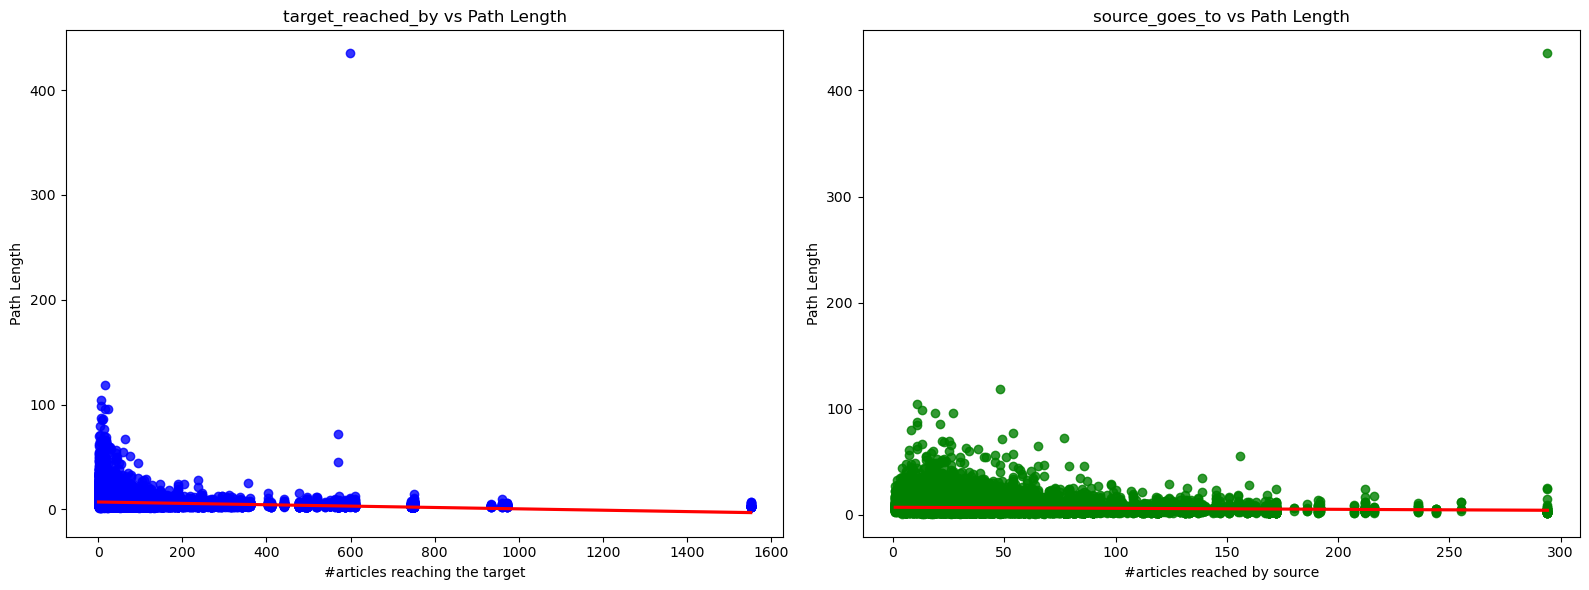

In [69]:
# Pearson and Spearman correlations for target_reached_by vs path_length
p_target = stats.pearsonr(tasks_finished["target_reached_by"], tasks_finished["path_length"])
s_target = stats.spearmanr(tasks_finished["target_reached_by"], tasks_finished["path_length"])

# Pearson and Spearman correlations for source_goes_to vs path_length
p_source = stats.pearsonr(tasks_finished["source_goes_to"], tasks_finished["path_length"])
s_source = stats.spearmanr(tasks_finished["source_goes_to"], tasks_finished["path_length"])

print(f"Pearson correlation (target_reached_by vs path_length): {p_target}")
print(f"Spearman correlation (target_reached_by vs path_length): {s_target}")
print(f"Pearson correlation (source_goes_to vs path_length): {p_source}")
print(f"Spearman correlation (source_goes_to vs path_length): {s_source}")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(x="target_reached_by", y="path_length", data=tasks_finished, scatter_kws={'color':'blue'}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_xlabel('#articles reaching the target')
axs[0].set_ylabel('Path Length')
axs[0].set_title('target_reached_by vs Path Length')

sns.regplot(x="source_goes_to", y="path_length", data=tasks_finished, scatter_kws={'color':'green'}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_xlabel('#articles reached by source')
axs[1].set_ylabel('Path Length')
axs[1].set_title('source_goes_to vs Path Length')

plt.tight_layout()
plt.show()


Pearson correlation (target_reached_by vs path_length): PearsonRResult(statistic=-0.2336772152119462, pvalue=0.0)
Spearman correlation (target_reached_by vs path_length): SignificanceResult(statistic=-0.262751003555058, pvalue=0.0)
Pearson correlation (source_goes_to vs path_length): PearsonRResult(statistic=-0.15122484381963255, pvalue=1.8833399812442884e-211)
Spearman correlation (source_goes_to vs path_length): SignificanceResult(statistic=-0.1443870191713148, pvalue=9.47058271746105e-193)


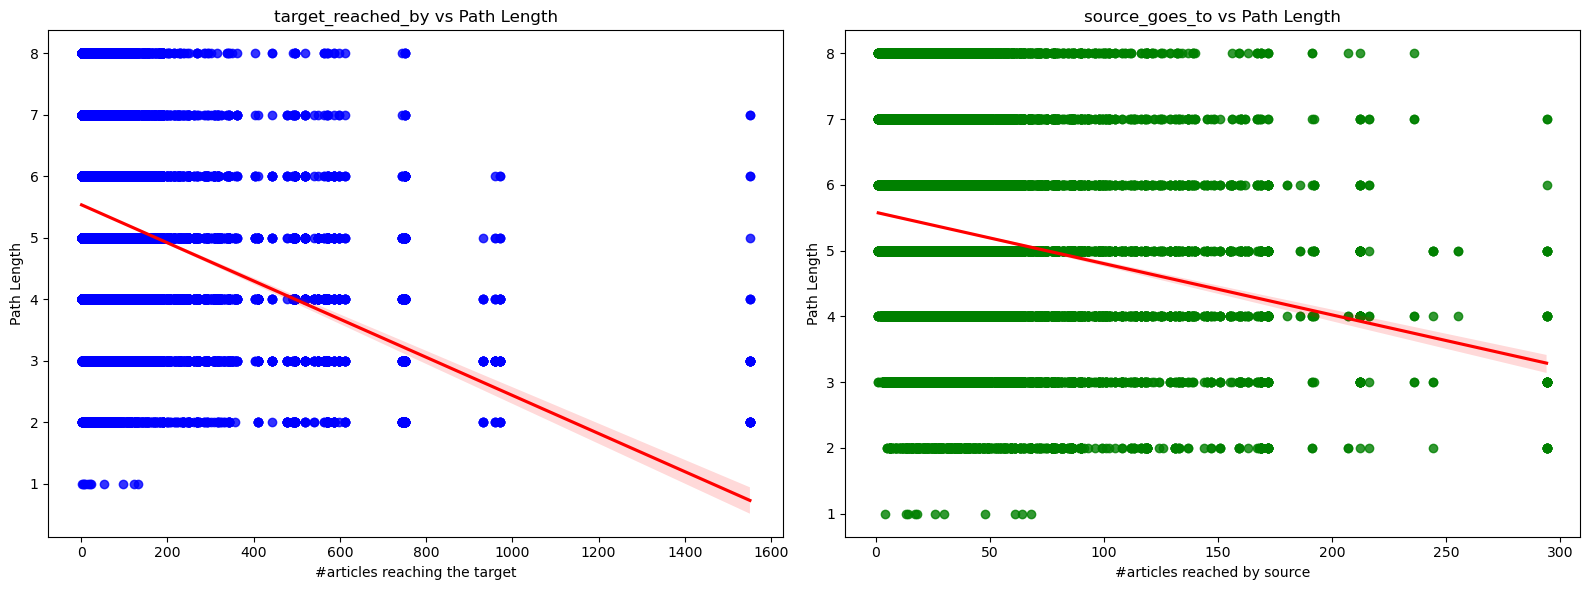

In [70]:
tasks_finished_shorts = tasks_finished[tasks_finished['path_length'] < 9]

# Pearson and Spearman correlations for target_reached_by vs path_length
p_target = stats.pearsonr(tasks_finished_shorts["target_reached_by"], tasks_finished_shorts["path_length"])
s_target = stats.spearmanr(tasks_finished_shorts["target_reached_by"], tasks_finished_shorts["path_length"])

# Pearson and Spearman correlations for source_goes_to vs path_length
p_source = stats.pearsonr(tasks_finished_shorts["source_goes_to"], tasks_finished_shorts["path_length"])
s_source = stats.spearmanr(tasks_finished_shorts["source_goes_to"], tasks_finished_shorts["path_length"])

print(f"Pearson correlation (target_reached_by vs path_length): {p_target}")
print(f"Spearman correlation (target_reached_by vs path_length): {s_target}")
print(f"Pearson correlation (source_goes_to vs path_length): {p_source}")
print(f"Spearman correlation (source_goes_to vs path_length): {s_source}")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(x="target_reached_by", y="path_length", data=tasks_finished_shorts, scatter_kws={'color':'blue'}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_xlabel('#articles reaching the target')
axs[0].set_ylabel('Path Length')
axs[0].set_title('target_reached_by vs Path Length')

sns.regplot(x="source_goes_to", y="path_length", data=tasks_finished_shorts, scatter_kws={'color':'green'}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_xlabel('#articles reached by source')
axs[1].set_ylabel('Path Length')
axs[1].set_title('source_goes_to vs Path Length')

plt.tight_layout()
plt.show()


Pearson correlation (target_reached_by vs duration): PearsonRResult(statistic=-0.07766200452623542, pvalue=2.1649893117533886e-69)
Spearman correlation (target_reached_by vs duration): SignificanceResult(statistic=-0.29237528357668235, pvalue=0.0)
Pearson correlation (source_goes_to vs duration): PearsonRResult(statistic=-0.020297312453712656, pvalue=4.321868903082615e-06)
Spearman correlation (source_goes_to vs duration): SignificanceResult(statistic=-0.06574754377188279, pvalue=3.3105241433066858e-50)


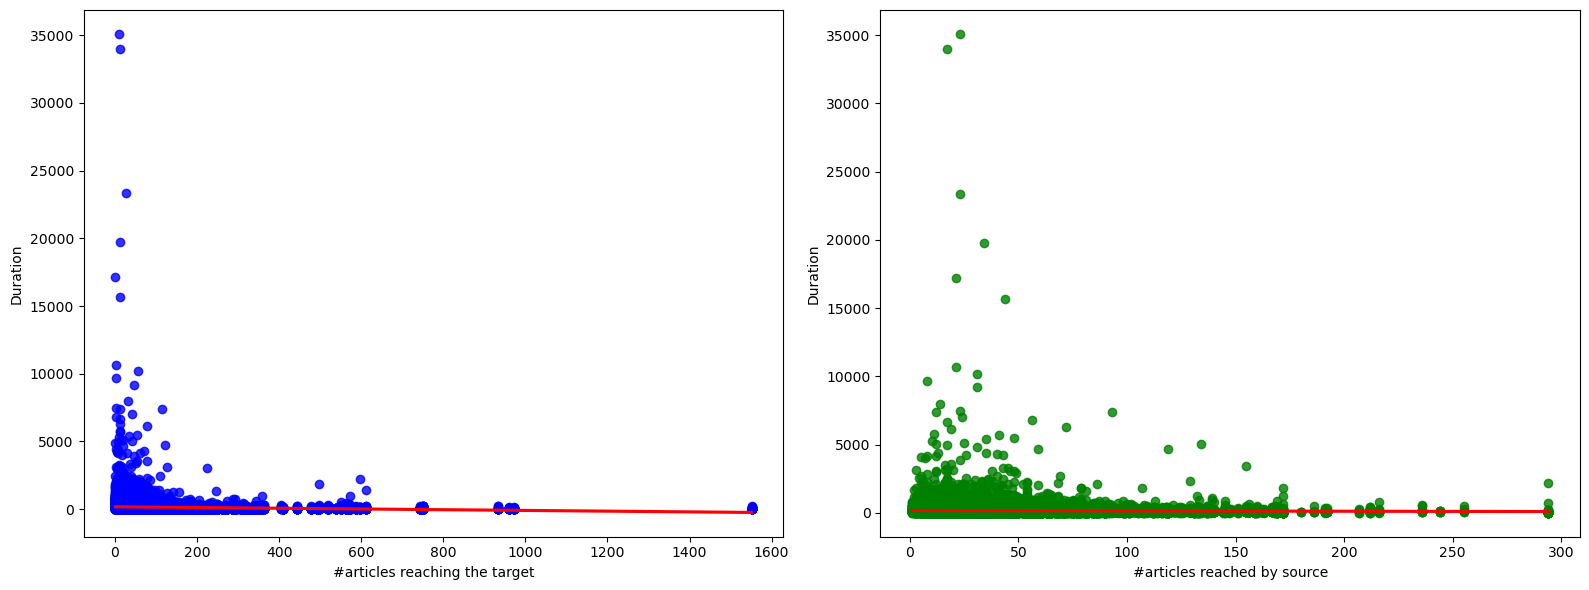

In [73]:
# Pearson and Spearman correlations for target_reached_by vs duration
p_target = stats.pearsonr(tasks_finished["target_reached_by"], tasks_finished["duration"])
s_target = stats.spearmanr(tasks_finished["target_reached_by"], tasks_finished["duration"])

# Pearson and Spearman correlations for source_goes_to vs duration
p_source = stats.pearsonr(tasks_finished["source_goes_to"], tasks_finished["duration"])
s_source = stats.spearmanr(tasks_finished["source_goes_to"], tasks_finished["duration"])

print(f"Pearson correlation (target_reached_by vs duration): {p_target}")
print(f"Spearman correlation (target_reached_by vs duration): {s_target}")
print(f"Pearson correlation (source_goes_to vs duration): {p_source}")
print(f"Spearman correlation (source_goes_to vs duration): {s_source}")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(x="target_reached_by", y="duration", data=tasks_finished, scatter_kws={'color':'blue'}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_xlabel('#articles reaching the target')
axs[0].set_ylabel('Duration')

sns.regplot(x="source_goes_to", y="duration", data=tasks_finished, scatter_kws={'color':'green'}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_xlabel('#articles reached by source')
axs[1].set_ylabel('Duration')

plt.tight_layout()
plt.show()

Pearson correlation (target_reached_by vs duration): PearsonRResult(statistic=-0.19976572411881696, pvalue=0.0)
Spearman correlation (target_reached_by vs duration): SignificanceResult(statistic=-0.23151568087086294, pvalue=0.0)
Pearson correlation (source_goes_to vs duration): PearsonRResult(statistic=-0.08049501054739835, pvalue=2.4004557743890153e-56)
Spearman correlation (source_goes_to vs duration): SignificanceResult(statistic=-0.06927614435602861, pvalue=3.677843665811883e-42)


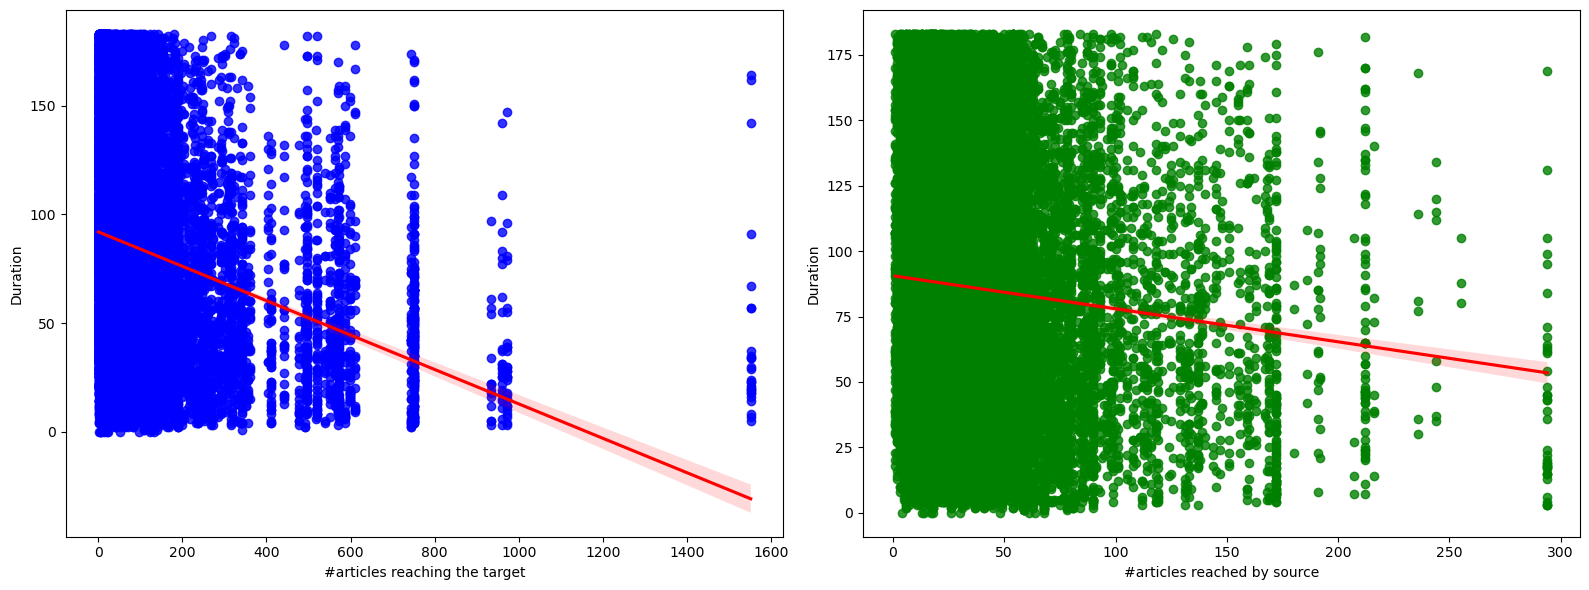

In [72]:
tasks_finished_shorts = tasks_finished[tasks_finished['duration'] <= 183]

# Pearson and Spearman correlations for target_reached_by vs duration
p_target = stats.pearsonr(tasks_finished_shorts["target_reached_by"], tasks_finished_shorts["duration"])
s_target = stats.spearmanr(tasks_finished_shorts["target_reached_by"], tasks_finished_shorts["duration"])

# Pearson and Spearman correlations for source_goes_to vs duration
p_source = stats.pearsonr(tasks_finished_shorts["source_goes_to"], tasks_finished_shorts["duration"])
s_source = stats.spearmanr(tasks_finished_shorts["source_goes_to"], tasks_finished_shorts["duration"])

print(f"Pearson correlation (target_reached_by vs duration): {p_target}")
print(f"Spearman correlation (target_reached_by vs duration): {s_target}")
print(f"Pearson correlation (source_goes_to vs duration): {p_source}")
print(f"Spearman correlation (source_goes_to vs duration): {s_source}")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(x="target_reached_by", y="duration", data=tasks_finished_shorts, scatter_kws={'color':'blue'}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_xlabel('#articles reaching the target')
axs[0].set_ylabel('Duration')

sns.regplot(x="source_goes_to", y="duration", data=tasks_finished_shorts, scatter_kws={'color':'green'}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_xlabel('#articles reached by source')
axs[1].set_ylabel('Duration')

plt.tight_layout()
plt.show()

Pearson correlation (target_reached_by vs rating): PearsonRResult(statistic=-0.16425914599700028, pvalue=2.225351963524492e-171)
Spearman correlation (target_reached_by vs rating): SignificanceResult(statistic=-0.24374249934132283, pvalue=0.0)
Pearson correlation (source_goes_to vs rating): PearsonRResult(statistic=-0.06492475735037738, pvalue=5.5165328211961565e-28)
Spearman correlation (source_goes_to vs rating): SignificanceResult(statistic=-0.06997769864250003, pvalue=2.990598389294959e-32)


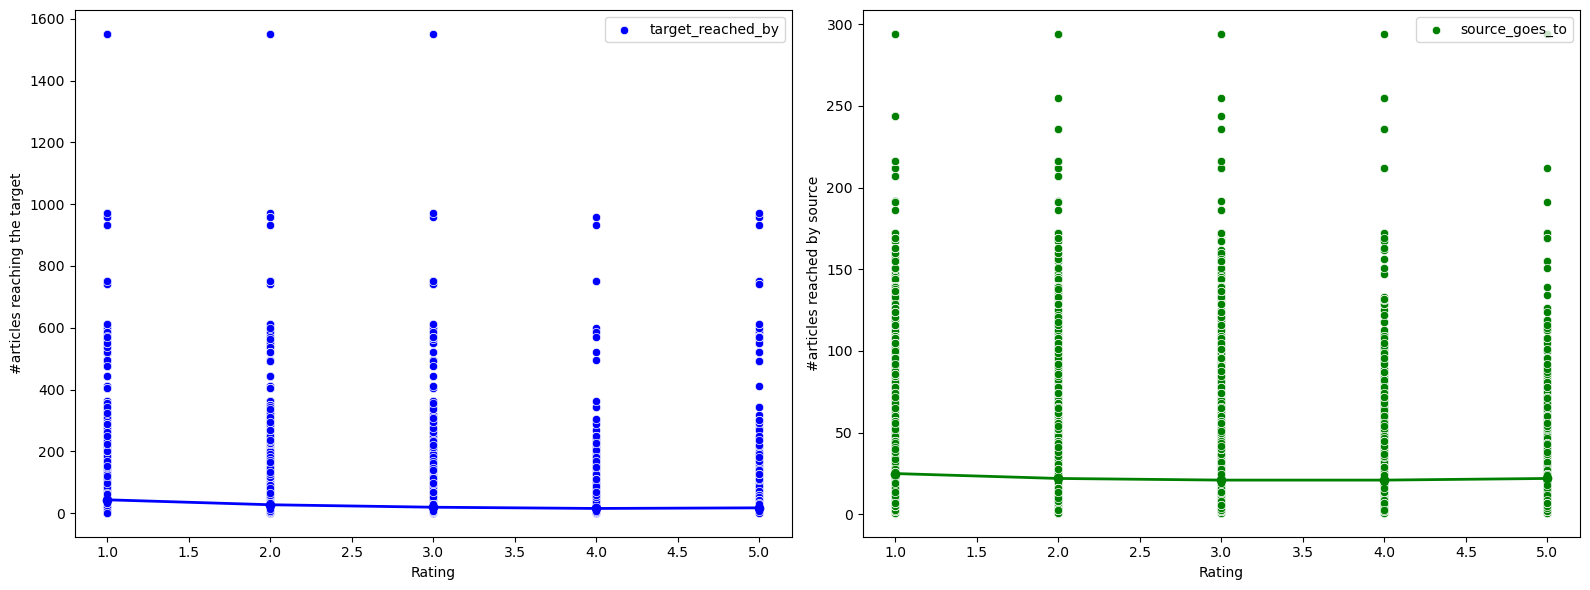

In [78]:
tasks_finished_rating=tasks_finished.dropna(subset=['rating'])

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Drop rows with NaN in 'rating'
tasks_finished_rating = tasks_finished.dropna(subset=['rating'])

# Pearson and Spearman correlations for target_reached_by vs rating
p_target = stats.pearsonr(tasks_finished_rating["target_reached_by"], tasks_finished_rating["rating"])
s_target = stats.spearmanr(tasks_finished_rating["target_reached_by"], tasks_finished_rating["rating"])

# Pearson and Spearman correlations for source_goes_to vs rating
p_source = stats.pearsonr(tasks_finished_rating["source_goes_to"], tasks_finished_rating["rating"])
s_source = stats.spearmanr(tasks_finished_rating["source_goes_to"], tasks_finished_rating["rating"])

print(f"Pearson correlation (target_reached_by vs rating): {p_target}")
print(f"Spearman correlation (target_reached_by vs rating): {s_target}")
print(f"Pearson correlation (source_goes_to vs rating): {p_source}")
print(f"Spearman correlation (source_goes_to vs rating): {s_source}")

# Compute the median of 'target_reached_by' and 'source_goes_to' for each rating
median_ratings = tasks_finished_rating.groupby('rating').agg({
    'target_reached_by': 'median',
    'source_goes_to': 'median'
}).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x="rating", y="target_reached_by", data=tasks_finished_rating, color='blue', ax=axs[0], label="target_reached_by")
axs[0].plot(median_ratings['rating'], median_ratings['target_reached_by'], color='blue', lw=2, marker='o', markersize=6)
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('#articles reaching the target')

sns.scatterplot(x="rating", y="source_goes_to", data=tasks_finished_rating, color='green', ax=axs[1], label="source_goes_to")
axs[1].plot(median_ratings['rating'], median_ratings['source_goes_to'], color='green', lw=2, marker='o', markersize=6)
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('#articles reached by source')

plt.tight_layout()
plt.show()
